In [2]:
import torch
import torch.nn.functional as F
from data import get_data_loaders

c:\Users\Cole\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, batchSize: int, maxSeq: int, vocabSize: int):
        super().__init__()
        # Input:  (batchSize x maxSeq x vocabSize)
        self.embed = torch.nn.Embedding(vocabSize, 150)
        self.layer1 = torch.nn.Linear(150, 40)
        # output: (batchSize x maxSeq x 4)
        self.layer2 = torch.nn.Linear(40, 2)
        self.layer3 = torch.nn.Linear(maxSeq, 1)

        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        # input:  (batchSize x maxSeq x vocabSize)
        output = self.embed(x)
        output = self.layer1(output)
        output = self.layer2(output)  # ( batchsize x maxSeq x 2)
        output = torch.transpose(output, 1, 2)
        output = self.layer3(output)
        output = self.softmax(output)
        return output


In [5]:
maxSeq, vocabSize, train_loader, test_loader, validation_loader = get_data_loaders(256)

Dataset initialized


In [6]:
from train import train_one_epoch, validate
def train(epochs=5, batchsize=200, learning_rate=0.001):
    model = NeuralNetwork(batchSize=batchsize, maxSeq=maxSeq, vocabSize=vocabSize).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    validation_accuracy = []
    trainings_loss = []
    for epoch in range(epochs):
        average_loss = train_one_epoch(model, train_loader, optimizer, device)
        round(average_loss, 5)
        trainings_loss.append(average_loss)
        validation_acc = validate(model, validation_loader, device)
        validation_accuracy.append(validation_acc)
        if epoch > 3:
            if trainings_loss[-2] <= trainings_loss[-1] and trainings_loss[-3] <= trainings_loss[-1]:
                print("Wasting time breaking")
                break
            if (validation_accuracy[-2] + validation_accuracy[-3]) / 2 > validation_acc:
                print("Not improving breaking")
                break
        print(
            f"Epoch {epoch}, Loss: {average_loss:.5f}, Validation Accuracy: {validation_acc:.5f}"
        )

    return model, trainings_loss, validation_accuracy

# Train The model

In [7]:
model, trainings_loss, validation_accuracy = train(epochs=5, batchsize=256, learning_rate=0.001)

Epoch training time: 0:31
Epoch 0, Loss: 0.67563, Validation Accuracy: 0.66927
Epoch training time: 0:31
Epoch 1, Loss: 0.57190, Validation Accuracy: 0.72998
Epoch training time: 0:31
Epoch 2, Loss: 0.53133, Validation Accuracy: 0.74212
Epoch training time: 0:32
Epoch 3, Loss: 0.51200, Validation Accuracy: 0.74212
Epoch training time: 0:23
Epoch 4, Loss: 0.49842, Validation Accuracy: 0.75311


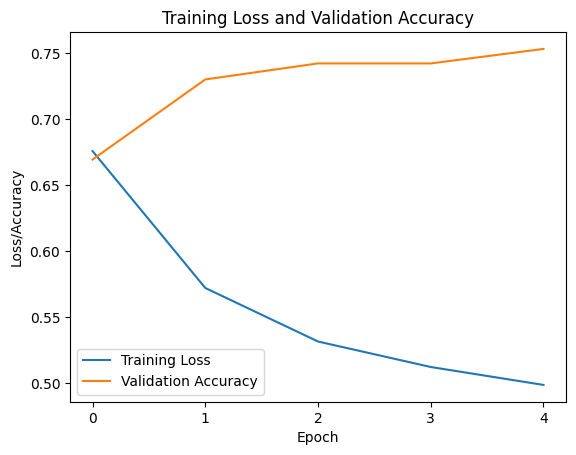

In [8]:
# plot the training loss and validation accuracy
import matplotlib.pyplot as plt
plt.plot(trainings_loss, label="Training Loss")
plt.plot(validation_accuracy, label="Validation Accuracy")
plt.title("Training Loss and Validation Accuracy")
plt.xlabel("Epoch")
# x label from 1 to 5
plt.xticks(range(0, 5))
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

# Test The model

In [9]:
def definingLabel(label: str):
    if label.lower() == "republican":
        y = [1]
    else:
        y = [0]
    return torch.tensor(y)

def test(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = len(test_loader.dataset)
        true_positive = 0
        false_positive = 0
        false_negative = 0
        for i, (x, y) in enumerate(test_loader):
            x = torch.stack(x, dim=1).int().to(device)
            y = torch.stack([definingLabel(label) for label in y]).to(device)
            output = model(x)
            output = torch.argmax(output, dim=1)
            correct += torch.sum(output == y).item()
            true_positive += torch.sum(output * y).item()
            false_positive += torch.sum(output * (1 - y)).item()
            false_negative += torch.sum((1 - output) * y).item()
        accuracy = correct / total
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        f1 = 2 * precision * recall / (precision + recall)
        print(f"Accuracy: {accuracy:.5f}, Precision: {precision:.5f}, Recall: {recall:.5f}, F1: {f1:.5f}")
        print("Confusion Matrix:")
        print(f"                    Predicted")
        print(f"                    Democrat    Republican")
        print(f"Actual  Democrat    {true_positive}        {false_negative}")
        print(f"        Republican  {false_positive}        {correct - true_positive}")
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = test(model, test_loader)

Accuracy: 0.75038, Precision: 0.75143, Recall: 0.76199, F1: 0.75668
Confusion Matrix:
                    Predicted
                    Democrat    Republican
Actual  Democrat    5369        1677
        Republican  1776        5011


# Add the text of a tweet to predit the label of unseen text

In [ ]:
# given text, predict the label
from transformers import BertTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
vocab = tokenizer.get_vocab()
stop_words = stopwords.words("english")
stemmer = PorterStemmer()

def predict(model, text):
    text = text.lower()
    text = tokenizer.tokenize(text)
    text = [stemmer.stem(word) for word in text if word not in stop_words]
    text = [vocab[word] for word in text if word in vocab]
    text = torch.tensor(text).unsqueeze(0).to(device)
    text = torch.nn.functional.pad(text, (0, maxSeq - text.size(1)), "constant", 0)
    output = model(text)
    output = torch.argmax(output, dim=1)
    return "Republican" if output.item() > 0 else "Democrat"

text = "The fight for racial justice is far from over. We must stand against systemic racism and work for real change in policing and criminal justice reform. #BlackLivesMatter #JusticeForAll"
print(f"Text: {text}\npredicted: {predict(model, text)}")
text = "America is a nation of hard work and personal responsibility. Government should get out of the way so that businesses can thrive and create jobs. #FreeMarkets #LessGovernment"
print(f"Text: {text}\npredicted: {predict(model, text)}")

Text: The fight for racial justice is far from over. We must stand against systemic racism and work for real change in policing and criminal justice reform. #BlackLivesMatter #JusticeForAll
predicted: Democrat
Text: America is a nation of hard work and personal responsibility. Government should get out of the way so that businesses can thrive and create jobs. #FreeMarkets #LessGovernment
predicted: Republican
